# Jupyter notebook to process the data

In [190]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [66]:
import pandas as pd; import numpy as np; 
import seaborn as sns; sns.set_context('talk', font_scale=.9)
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
from scipy.stats import ttest_ind

## Get the raw data

In [2]:
control_raw = pd.read_csv('control-results.tsv', sep='\t')
treated_raw = pd.read_csv('50ppm-results.tsv', sep='\t')

In [185]:
control_raw.loc[:,['Young\'s modulus (Pa)','R Squared']].describe().T

,count,mean,std,min,25%,50%,75%,max
Young's modulus (Pa),63.0,109.556557,61.657542,-3.9702,89.41275,119.6419,140.6947,234.5810
R Squared,63.0,0.932379,0.197514,-0.4768,0.95890,0.9885,0.9935,0.9971


In [186]:
treated_raw.loc[:,['Young\'s modulus (Pa)','R Squared']].describe().T

,count,mean,std,min,25%,50%,75%,max
Young's modulus (Pa),78.0,72.784323,59.451879,-4.6358,3.885550,83.1796,110.4565,254.2959
R Squared,78.0,0.841868,0.313034,-0.8340,0.896425,0.9789,0.9935,0.9982


***The data needs to be cleaned***

It comes from bulk processing of force curves, and some of them are not valid curves.

## Cleaning the data

We know Young's modulus can not be negative. We can also use the R squared to filter good fittings.


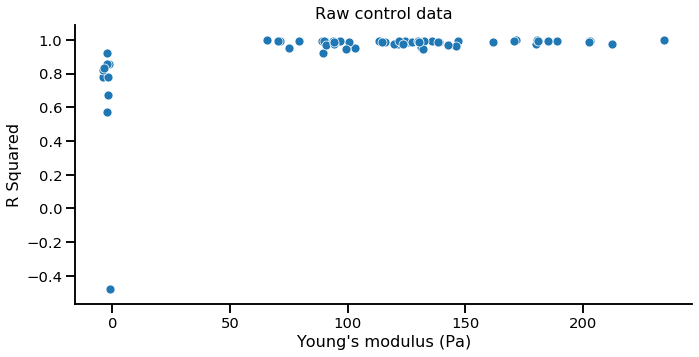

In [52]:
sns.relplot(data = control_raw, x = 'Young\'s modulus (Pa)', y = 'R Squared', aspect = 2)
plt.title('Raw control data')
plt.show()

Some curves were fitted wit negative $E$ or $R^2$. In this case, we can get rid of the poorly fitted curves by selecting only the curves with $E$ < 50 Pa.



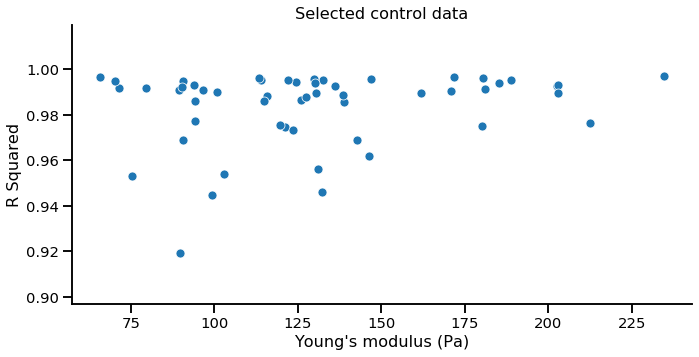

In [53]:
control = control_raw[control_raw['Young\'s modulus (Pa)'] > 50]
sns.relplot(data = control, x = 'Young\'s modulus (Pa)', y = 'R Squared', aspect = 2)
plt.title('Selected control data')
plt.show()

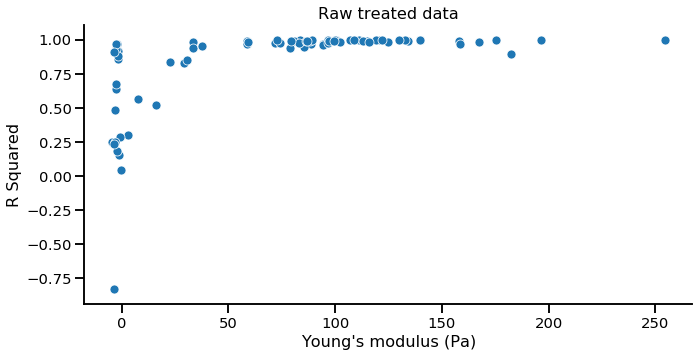

In [54]:
sns.relplot(data = treated_raw, x = 'Young\'s modulus (Pa)', y = 'R Squared', aspect = 2)
plt.title('Raw treated data')
plt.show()

For the treated cells, we need a different criteria. Some values below 50 Pa had a fairly good $R^2$. 
Then, the criteria can be $E$ > 10, $R^2$ > 0.8

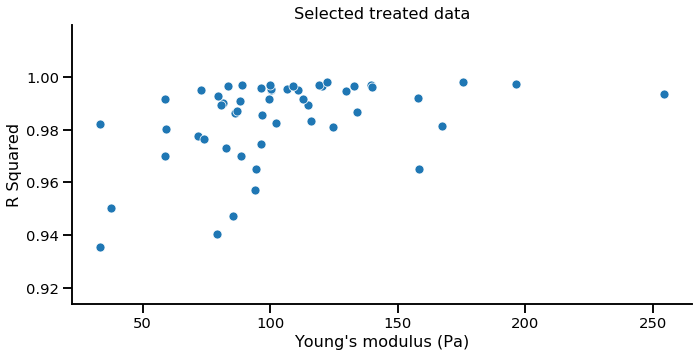

In [55]:
treated = treated_raw[(treated_raw['Young\'s modulus (Pa)'] > 0) & (treated_raw['R Squared']>.9)]
sns.relplot(data = treated, x = 'Young\'s modulus (Pa)', y = 'R Squared', aspect = 2)
plt.title('Selected treated data')
plt.show()

## Create a dataframe with $E$ values only

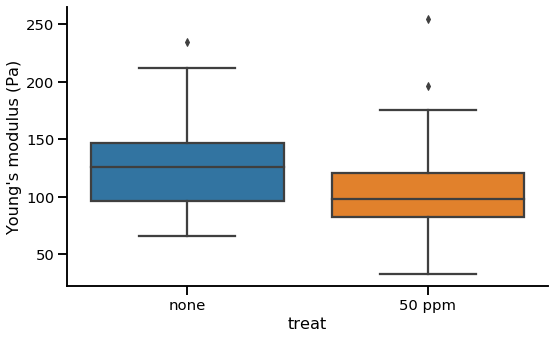

In [51]:
control['treat'] = 'none'
treated['treat'] = '50 ppm'

df = control.append(treated)

sns.catplot(data = df, x= 'treat' , y = 'Young\'s modulus (Pa)', aspect = 1.6,  kind='box')
plt.show()

***Non-treated info***

In [187]:
control.loc[:,['Young\'s modulus (Pa)','R Squared']].describe().T

,count,mean,std,min,25%,50%,75%,max
Young's modulus (Pa),53.0,130.687608,40.809077,65.7099,96.6275,125.8422,146.8337,234.5810
R Squared,53.0,0.983619,0.016545,0.9192,0.9763,0.9905,0.9943,0.9971


***50 ppm treated info***

In [189]:
treated.loc[:,['Young\'s modulus (Pa)','R Squared']].describe().T

,count,mean,std,min,25%,50%,75%,max
Young's modulus (Pa),52.0,104.508069,39.936009,33.2966,82.512575,98.28985,120.74525,254.2959
R Squared,52.0,0.984337,0.015634,0.9354,0.979600,0.99070,0.99575,0.9982


***It seems the cells exposed to nanoparticles are softer***. 

Are the differences significant?

In [108]:
E_treat = df[df['treat'] == '50 ppm']['Young\'s modulus (Pa)'].values
E_control = df[df['treat'] == 'none']['Young\'s modulus (Pa)'].values
diff, P = ttest_ind(E_treat, E_control)
print('P = {0:3.4f}'.format(P))

P = 0.0012


***$P$ < 0.05, differences are significant.***

# Just for fun...

What if I take random samples of 20 Young's modulus of each population?

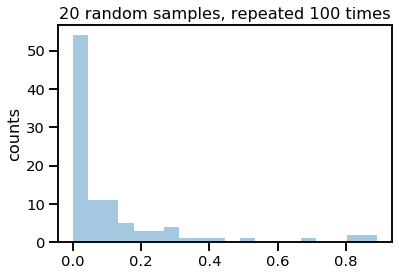

In [191]:
n = 20
p = []
for i in range(100):
    np.random.seed(i)
    control_sample = np.random.choice(E_control, size = n)
    treat_sample = np.random.choice(E_treat, size = n)
    diff, P = ttest_ind(treat_sample, control_sample)
    p.append(P)

sns.distplot(p, bins = 20, kde=False) 
plt.title('20 random samples, repeated 100 times')
#plt.xlabel('P-value')
plt.ylabel('counts')
plt.show()


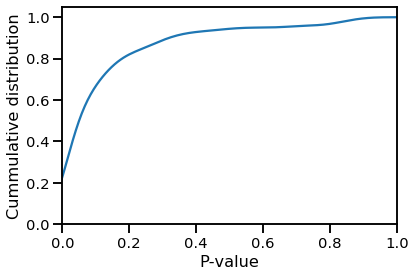

In [184]:
kwargs = {'cumulative': True}
sns.distplot(p, hist = False, kde_kws=kwargs) 
plt.ylabel('Cummulative distribution')
plt.xlim(0,1)
plt.xlabel('P-value')
plt.show()

**Then, we have P < 0.05 ONLY in $\approx$50 % of the times, for a sample of 20 force curves, randomly selected ***